<font size=8>Dimensionality Reduction with PCA</font>

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os, sys

%matplotlib inline
import matplotlib.pyplot as plt

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
import matplotlib as mpl
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# Ignore useless warnings (see SciPy issue #5998)
# import warnings
# warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Dimensionality Reduction

Working in high-dimensional spaces is often unconvenient or even impossible. One might want to reduce the dimensionality in order to:
* Make visualizations
* Save storage space of the data (compression)
* Reduce computational costs of training algorithms, by reducing number of features.
* Increase a models performance by increasing the signal/noise ratio, as well as the density of points (*curse of dimensionality*).

The problem of reducing the dimensionality of features, while retaining most of the information, is called *dimensionality reduction* and there are two main approaches to it:
* Projection: Project the high-dimensional space into a hyper-plane, collapsing all the features orthogonal to it.
* Manifold-Learning: Learning the geometry of a lower-dimensional manifold, and projecting the data onto it.

On the first category, the most known algorithm is Principal Component Analysis.

## Principal Component Analysis

The aim of Principal Component Analysis is to find the direction onto which to project the data with minimum information loss.

We will see this in action, but first, let's take a more intuitive, naive approach to the problem by looking at a toy example.

However, the chosen direction is clearly **not the best**. 

**Can you draw the directions that you think would produce a better conservation of the data information? Why?**

### Runnning PCA

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Create independent random Gaussian data (200 points)
m = 200
np.random.seed(3)
X_base = np.random.randn(m, 2) 

# Check dimension of resulting array (matrix)
print(X_base.shape)

(200, 2)


In [3]:
# Define angle by which to rotate and factor by which to stretch the data
angle = np.pi / 8
stretch = 5

# Stretch matrix
S = np.array([[stretch, 0],
              [0, 1]])

# Rotation matrix
R = np.array([[np.cos(angle), np.sin(angle)], 
              [-np.sin(angle), np.cos(angle)]])

# Stretch
X = X_base @ S
# Rotate
X = X @ R

Text(0, 0.5, '$X_2$')

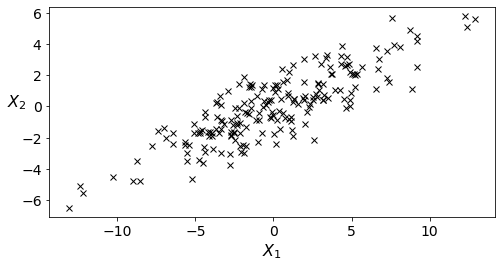

In [4]:
# Let's take a look at the resulting dataset 
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X.T, marker='x', color='k', ls='')
ax.set_aspect('equal')
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16, rotation=0)

Let's see the implementation in `sklearn`.

In this case, we are dealing with a `Transformer` class (not to be confused with the popular Deep Learning models). In `sklearn`, these classes have a `.fit` method, that takes a dataset as argument, and learns some parameters from it. In this case, it learns the covariance matrix from the data and how to invert it. They also have a `transform` method, that uses the learnt parameters to perform some transformation on the dataset. In this case convert the original dataset to the reduced set.

Finally, the `fit_transform` method concatenates both steps.

It is important for PCA that the dataset is normalised. We will then another transformer we have already seen.

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Instatiate scaler and scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find the principal components (how many components do we want?)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

**Explore the shape of the output. Does it make sense?**

In [14]:
print(X.shape, X_pca.shape)

(200, 2) (200, 2)


The coordinates of the axes chosen to project (i.e. the Principal Components) are stored in the `components_` attribute, row-wise.

In [15]:
pca.components_.shape

(2, 2)

**Let's see this directions in the plot above**

Text(0, 0.5, '$X_2$')

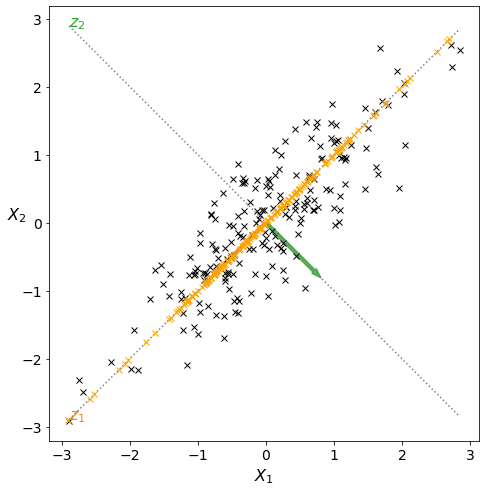

In [18]:
# Let's take a look at the resulting dataset 
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X_scaled.T, marker='x', color='k', ls='')
ax.set_aspect('equal')

z = pca.components_

imin = np.argmin(X[:, 0])
imax = np.argmax(X[:, 0])

for i in range(len(z)):
    #
    # slope of direction
    m = z[i, 0] / z[i, 1]
    
    # Plot line
    ax.plot([X_scaled[imin, 0], X_scaled[imax, 0]], 
            [X_scaled[imin, 0] * m, X_scaled[imax, 0] * m], 
            ls=':', color='gray')
    
    # Plot arrow
    size=1.0
    ax.arrow(0, 0, z[i, 0]*size, z[i,1]*size, color='C{}'.format(i+1), width=0.05, head_width=0.1, alpha=0.8,
             label='First PC')
    
    # Annotate new axes
    ax.annotate('$z_{}$'.format(i+1), [X_scaled[imin, 0], X_scaled[imin, 0]*m], fontsize=16, color='C{}'.format(i+1))

# Uncomment these lines to plot proyections onto the first PC (set zero on second component)
# X_pca_cut = X_pca.copy()
# X_pca_cut[:, 1] = 0
# X_1 = pca.inverse_transform(X_pca_cut)
# ax.plot(*X_1.T, 'x', color='orange', ls='')

# Labels
ax.set_xlabel('$X_1$', fontsize=16)
ax.set_ylabel('$X_2$', fontsize=16, rotation=0)

### Data in the transformed axes

Text(0, 0.5, '$z_2$')

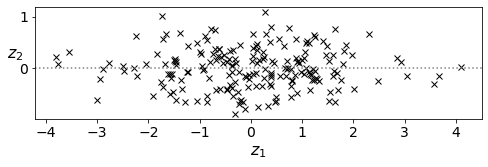

In [17]:
# In the transformed axis, the data look like an aligned elipsoid
ax = plt.figure(figsize=(8, 8)).add_subplot(111)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
ax.plot(*X_pca.T, marker='x', color='k', ls='')
ax.set_aspect('equal')

ax.axhline(0.0, color='gray', ls=':')

# Labels
ax.set_xlabel('$z_1$', fontsize=16)
ax.set_ylabel('$z_2$', fontsize=16, rotation=0)

**Question**. Can you say what each new coordinate $z$ represent?

We can easily go back to the original space using the `inverse_transform` method. **Complete the code below with the right input for this method**. Note that the code check if the reconstruction was done correctly.

In [19]:
X_reconstructed = pca.inverse_transform(X_pca)

print('Is the reconstruction perfect? {}'.format('Yes' if np.allclose(X_scaled, X_reconstructed) else 'No'))

Is the reconstruction perfect? Yes


**Question**. Did we lose any information by going to the PCA space and back? Did we reduced the dimensionality of the dataset?

### Incomplete reconstruction

Going to the PCA space and back is not a reduction dimensionality task, and therefore does produce any information loss. Let's see what happens if we only keep the projection of the data onto the first principal component.

In [20]:
# Run PCA with a single component
pca = PCA(n_components=1)
X_pca_1D = pca.fit_transform(X_scaled)

If we do the inverse transform, some information was lost, and so the inverted data is not the same as the original:

In [21]:
X_reconstructed = pca.inverse_transform(X_pca_1D)
print('Is the reconstruction perfect? {}'.format('Yes' if np.allclose(X_scaled, X_reconstructed) else 'No'))

Is the reconstruction perfect? No


Let's take a look at this compressed data, and how it looks like:

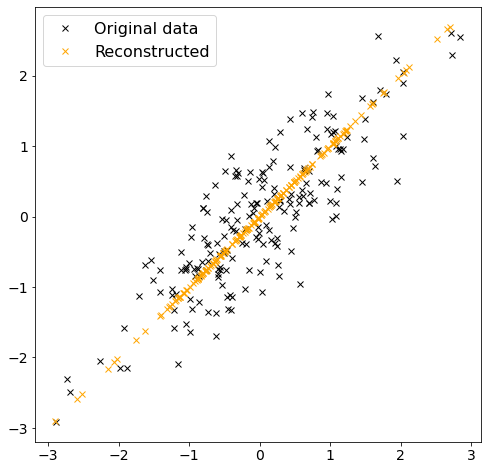

In [22]:
ax = plt.figure(figsize=(8, 8)).add_subplot(111)
ax.plot(*X_scaled.T, marker='x', color='k', ls='', label='Original data')
ax.plot(*X_reconstructed.T, marker='x', color='orange', ls='', label='Reconstructed')
ax.legend(fontsize=16)
ax.set_aspect('equal')

This is exactly the projection on the direction given by the first principal component. In this way, the resulting compressed dataset retains the maximum possible variance. 

If we look at the covariance matrix, we see that not much was lost:

In [23]:
print('Original covariance matrix\n', np.cov(X_scaled.T))
print('\nCompressed covariance matrix\n', np.cov(X_reconstructed.T))

Original covariance matrix
 [[1.00502513 0.85070879]
 [0.85070879 1.00502513]]

Compressed covariance matrix
 [[0.92786696 0.92786696]
 [0.92786696 0.92786696]]


The fraction of the total variance (information) kept by each principal component is stored in the `explained variance_ratio_` attribute:

In [24]:
pca.explained_variance_ratio_

array([0.92322762])

This shows that the projecting in the direction of the first PC retains over 92% of the data variance, while reducing the data dimension why half!

### Application on a high-dimensional dataset

Finding an optimal lower-dimensional representation of our data, allows us to store it using less space and reconstruct it loosing as little information as possible. Let's see how this works with images:

In [25]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X_mnist = mnist["data"]/255.0 # notice the normalisation
t_mnist = mnist["target"]

In [26]:
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = plt.cm.binary, **options)
    plt.axis("off")

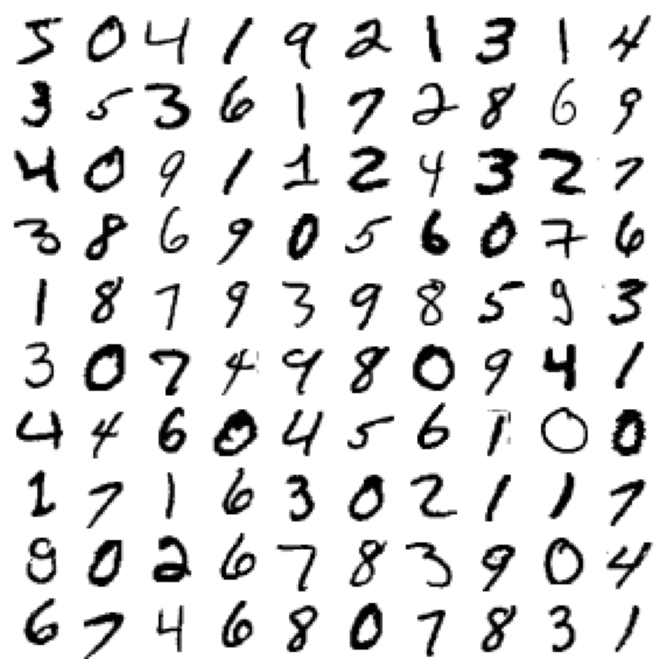

In [28]:
fig = plt.figure(figsize=(12, 12))
plot_digits(X_mnist[:100], 10)

Each digit consits on 784 pixels. Let's see how the reconstructed images when we use PCA to store it as a lower-dimensional vector.

In [29]:
pca = PCA(n_components=150)

X_reduced = pca.fit_transform(X_mnist)
X_recovered = pca.inverse_transform(X_reduced)

In [30]:
print(X_mnist.shape, X_reduced.shape, X_recovered.shape)

(70000, 784) (70000, 150) (70000, 784)


Text(0.5, 1.0, 'Compressed')

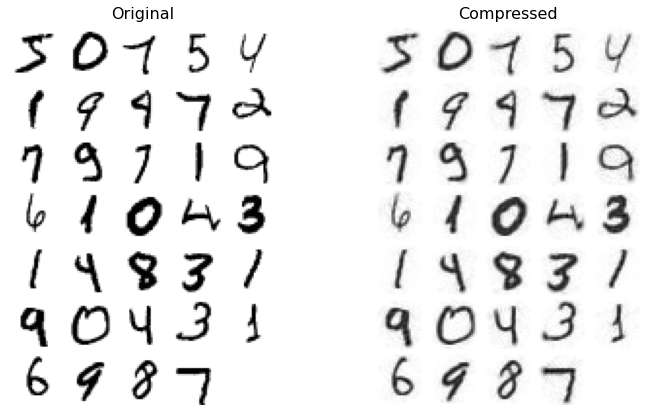

In [31]:
plt.figure(figsize=(12, 7))
plt.subplot(121)
plot_digits(X_mnist[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(np.abs(X_recovered[::2100]))
plt.title("Compressed", fontsize=16)

If we're not sure about what dimensionality should we impose, we can plot the cumulative sum of the explained variance ratio to see how much information is lost. If all features are used, it should be 1

In [32]:
pca = PCA()
pca.fit(X_mnist) #fit without reducing dimensionality

PCA()

In [33]:
# See the first elements of the explaned variance
print(pca.explained_variance_ratio_[:10])

[0.09746116 0.07155445 0.06149531 0.05403385 0.04888934 0.04305227
 0.03278262 0.02889642 0.02758364 0.0234214 ]


It is interesting to see how many components we need to keep to preserve a given variance level. For example, 95%. To do this, we can compute the *cumulative sum* of the explained variance ratios.

With 154 dimensions, we preserve 0.95 of the variance.


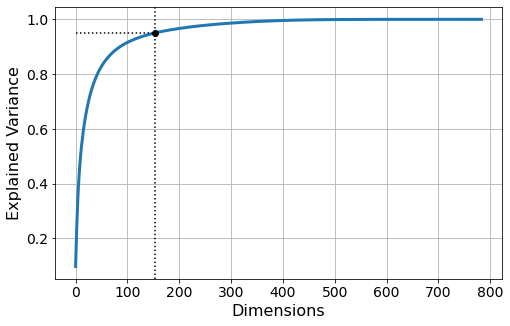

In [34]:
# Define what fraction of the variance you wish to keep
var_frac = 0.95

# Compute the cumulative sum and plot it
cumsum = np.cumsum(pca.explained_variance_ratio_) 
#this tells us how much information is retained if we stop at each dimension

# At what moment does the cumulative zoom reach var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('With {} dimensions, we preserve {} of the variance.'.format(d, var_frac))

plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=3)
# plt.axis([0, 400, 0, 1])

plt.axvline(d, color="k", ls=":")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")

plt.xlabel("Dimensions", fontsize=16)
plt.ylabel("Explained Variance", fontsize=16)

plt.grid(True)

### Visualizing PCs

Although the task we are dealing with here is dimensionality reduction, the directions given by the principal components can also be thought of as individual instances in the data space, therefore corresponding to one 28 x 28 pixel image each.

One may wonder how do the first few PCs look like for this dataset. 

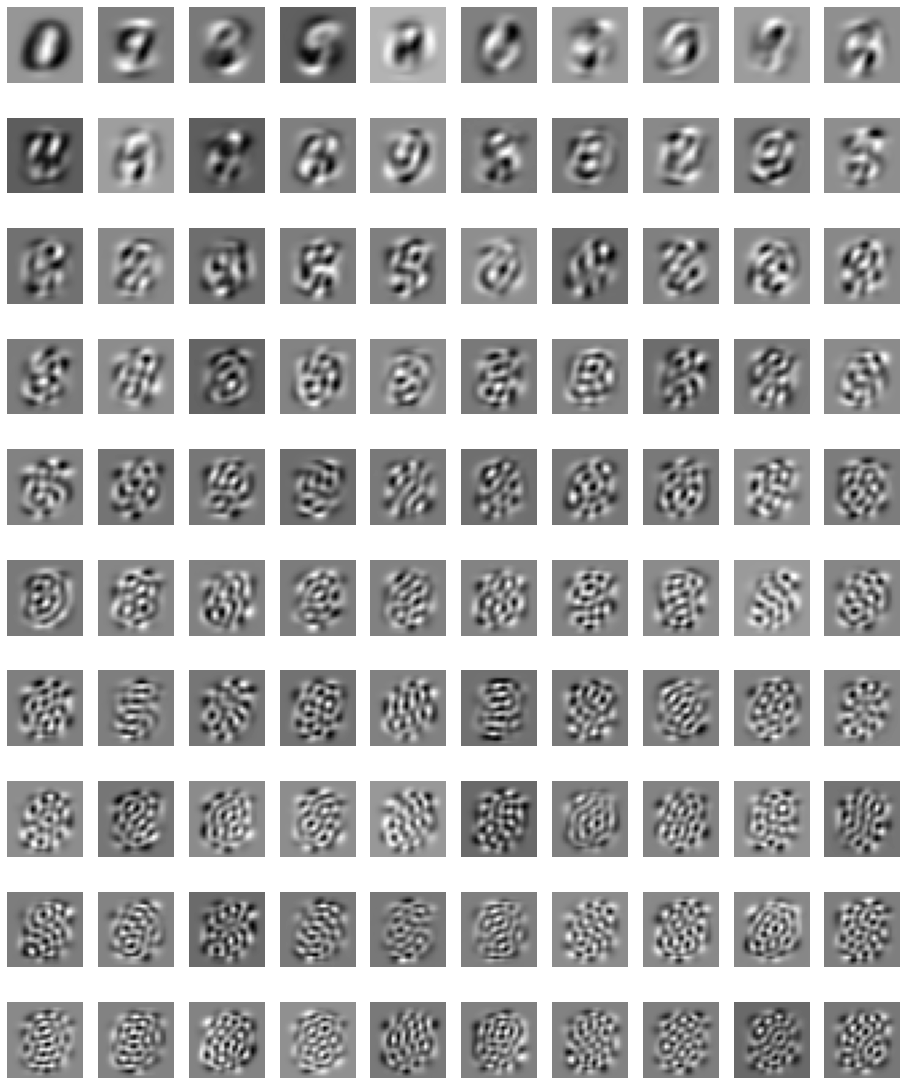

In [35]:
npc = 100

ncolumns = 10
nrows = npc // ncolumns

# Add extra row, if necessary
if npc % ncolumns:
    nrows += 1

fig, axs = plt.subplots(nrows, ncolumns, figsize=(16, 2*nrows))

for i, ax in zip(range(npc), axs.flatten()):
    pci_reshaped = pca.components_[i].reshape(28,28)
    ax.imshow(pci_reshaped, cmap='gray_r')
    ax.axis('off')

**Question.** Do you see anything worth mentioning from these figures?

Note how the type of image change as we move from the first few PCs to the high-order ones. What do you think this means?

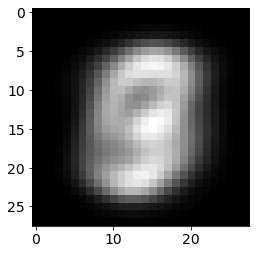

In [36]:
# We can also plot the mean
plt.imshow(pca.mean_.reshape(28, 28), cmap='gray')

### Give me five!

Repeat using only fives

In [38]:
X_mnist_5 = X_mnist[t_mnist==5]

In [39]:
pca = PCA()
pca.fit(X_mnist_5) #fit without reducing dimensionality

PCA()

**Question**: do you think we will need more or less PCs to reach 95% variance?

With 130 dimensions, we preserve 0.95 of the variance.


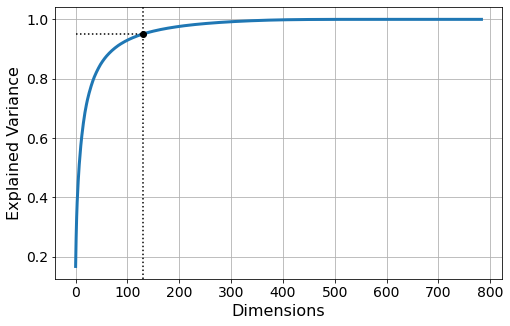

In [40]:
# Define what fraction of the variance you wish to keep
var_frac = 0.95

# Compute the cumulative sum and plot it
cumsum = np.cumsum(pca.explained_variance_ratio_) 
#this tells us how much information is retained if we stop at each dimension

# At what moment does the cumulative zoom reach var_frac * 100 %?
d = np.argmax(cumsum >= var_frac) + 1
print('With {} dimensions, we preserve {} of the variance.'.format(d, var_frac))

plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=3)
# plt.axis([0, 400, 0, 1])

plt.axvline(d, color="k", ls=":")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")

plt.xlabel("Dimensions", fontsize=16)
plt.ylabel("Explained Variance", fontsize=16)

plt.grid(True)

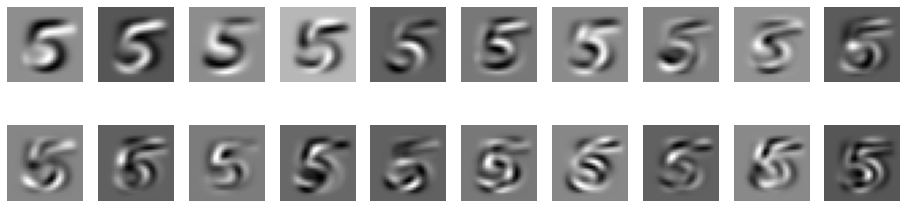

In [43]:
npc = 20

ncolumns = 10
nrows = npc // ncolumns

# Add extra row, if necessary
if npc % ncolumns:
    nrows += 1

fig, axs = plt.subplots(nrows, ncolumns, figsize=(16, 2*nrows))

for i, ax in zip(range(npc), axs.flatten()):
    pci_reshaped = pca.components_[i].reshape(28,28)
    ax.imshow(pci_reshaped, cmap='gray_r')
    ax.axis('off')

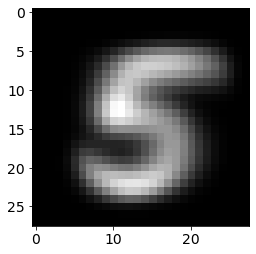

In [42]:
# We can also plot the mean
plt.imshow(pca.mean_.reshape(28, 28), cmap='gray')

# Play time! Eigenfaces

We invite you to build a Face Recognizer using PCA:

* Use PCA to project the dataset in the N principal components (try N=150 for example)
* Plot the image corresponding to the first few (20? 30?) principal components (an *eigenface*)

In [51]:
# Read data
from sklearn import datasets

lfw_people = datasets.fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [52]:
X_people = lfw_people.data

# Number of features
n_features = X.shape[1]

# The label to predict is the id of the person
t = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print('A dataset with {} instances of {} features and {} classes.'.format(len(X), n_features, n_classes))

A dataset with 1288 instances of 1850 features and 7 classes.


In [53]:
# Who are these people?
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [54]:
# Is the dataset balanced?
for i in range(len(target_names)):
    print(target_names[i],':',sum(t == i))

Ariel Sharon : 77
Colin Powell : 236
Donald Rumsfeld : 121
George W Bush : 530
Gerhard Schroeder : 109
Hugo Chavez : 71
Tony Blair : 144


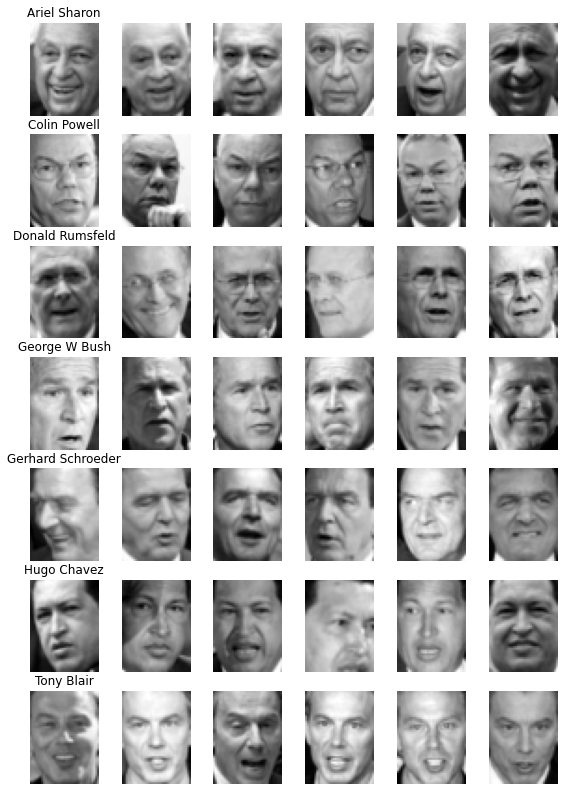

In [55]:
#lets plot a few of examples
n_pics_per_person = 6

n_cols = n_pics_per_person
n_rows = len(target_names)

fig, axs = plt.subplots(n_rows, n_cols, figsize=(1.6*n_cols, 2*n_rows))

for i in range(len(target_names)):
    # Select instances of that class
    Xi = X_people[t == i]
    # Randomly select n_pics_per_person
    idj = np.random.choice(len(Xi), size=n_pics_per_person, replace=False)
    
    for j, jj in enumerate(idj):
        axs[i, j].imshow(Xi[jj].reshape(50, 37), cmap='gray')
        axs[i, j].axis('off')
    axs[i, 0].set_title(target_names[i])

## Run PCA on this dataset

In [56]:
pca = PCA()
pca.fit(X_people)

PCA()

In [57]:
print(len(pca.components_))

1288


Note that here we have as many components as instances, not as features. If we don't specify, PCA takes the minimum between number of features and number of instances.

In [58]:
print(pca.components_.shape)

(1288, 1850)


Principal Components live in data space. They can therefore be visualised. Let us see the first few (more important) PCs, together with the data mean.
Remember that each principal component lives in original space (i.e. 1850 features)

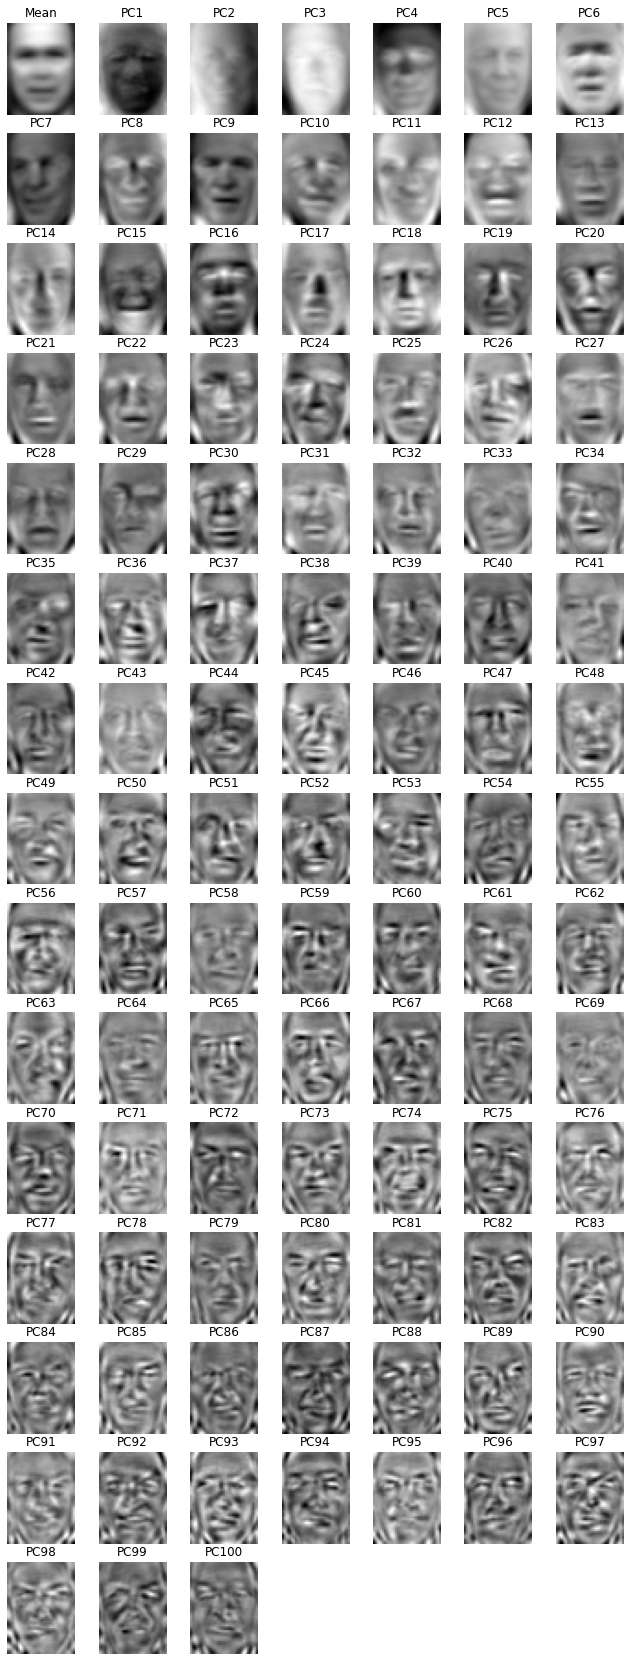

In [59]:
n_eigenfaces = 100
n_cols = 7

n_rows = (n_eigenfaces + 1) // n_cols
if (n_eigenfaces + 1) % n_cols:
    n_rows += 1

# Prepare grid of subplot
fig, axs = plt.subplots(n_rows, n_cols, figsize=(1.6*n_cols, 2*n_rows))

# Remove axes for all
for ax in axs.flatten():
    ax.set_axis_off()

# plot mean face
_ = axs.flatten()[0].imshow(pca.mean_.reshape(50, 37), cmap='gray')
_ = axs.flatten()[0].set_title('Mean')

# plot eigenfaces
for i, ax in zip(range(n_eigenfaces), axs.flatten()[1:]):
    eigenface = pca.components_[i]
    _ = ax.imshow(eigenface.reshape(50,37), cmap = plt.cm.gray)
    _ = ax.set_title('PC{}'.format(i+1))

Now let us explore how much variance is explained? Let's see the first 10 elements.

In [60]:
pca.explained_variance_ratio_[: 10]

array([0.18831754, 0.15066957, 0.07268994, 0.06034759, 0.05140407,
       0.0303295 , 0.02475534, 0.02107426, 0.0203735 , 0.01916663],
      dtype=float32)

Quite impressive! The first two PCs explain about 34% of the images variabilities. This is much better than the MNIST dataset

In [61]:
cumsum = np.cumsum(pca.explained_variance_ratio_) #this tells us how much information is retained if we stop at each dimension

As above we can set a threhold of how much variance we want to retain, and use it to estimate the number of dimensions

In [62]:
d = np.argmax(cumsum >= 0.95) + 1
print(d)

142


With 135 dimensions, we preserve 95% of the variance

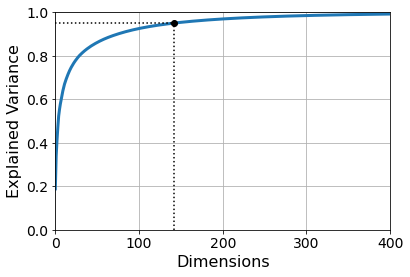

In [63]:
plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])

plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")

plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")

plt.grid(True)
plt.show()

## Reconstructing me softly

It is interesting to see how an image is recovered progressively as we add more and more PCs to the reconstruction.

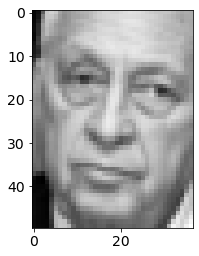

In [65]:
idx = 45
plt.imshow(X_people[idx].reshape(50, 37), cmap='gray')

In [67]:
# Let us compute the coefficients for this specific image
coef = pca.transform([X_people[idx],])
print(coef.shape, pca.components_.shape)

(1, 1288) (1288, 1850)


In [68]:
# Compute elements corresponding to each PC
partial = coef.T * pca.components_ 

# Build cumulative reconstructions
cpartial = np.cumsum(partial, axis=0)

Each element in `cpartial` then has the reconstruction with an increasing number of PCs (except for the mean).

Let's see this at work.

Text(0.5, 1.0, 'Original')

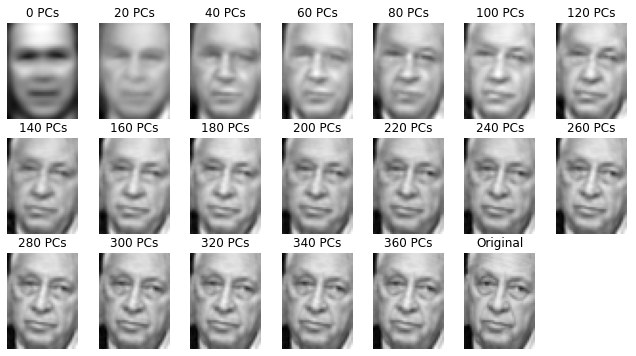

In [70]:
# Maximum number of PCs to use in reconstruction
max_summed_elements = 350

# Thin factor, plot one reconstruction every `thin`
thin = 20

# Plotting definitions (n_columns, n_rows, etc)
n_images = max_summed_elements // thin + 2 # sum two for mean and original
n_cols = 7

n_rows = n_images // n_cols
if n_images % n_cols:
    n_rows += 1

# Prepare grid of subplot
fig, axs = plt.subplots(n_rows, n_cols, figsize=(1.6*n_cols, 2*n_rows))
for ax in axs.flatten():
    ax.set_axis_off()

# plot eigenfaces
for i, ax in zip(range(n_images), axs.flatten()):
    if i == 0:
        # Plot mean as first reconstruction
        reconstruction = pca.mean_.reshape(50, 37)
    else:    
        reconstruction = cpartial[i*thin]
    ax.imshow(reconstruction.reshape(50,37) + pca.mean_.reshape(50, 37), cmap = plt.cm.gray)
    ax.set_title('{} PCs'.format(i*thin))

axs.flatten()[i+1].imshow(X_people[idx].reshape(50, 37), cmap='gray')
axs.flatten()[i+1].set_title('Original')

In agreement with what we saw above, most of the information of the original image is recovered using ~140 PCs.

# "See you in the future"

## Kernel PCA

A variant of PCA used to learn non-linear mappings is called *kernel-PCA*, which makes use of the *kernel trick* to map the original features into a higher-dimensional (maybe infinite-dimensional) space, in which PCA is applied. This is useful to learn more complex non-linear transformations.

**Note**. Kernel methods are taught in the second course on **Advanced topics**. Please join us if you want to know how these techniques work.

Kernel PCA has the **strong** disadvantage that the inverse transformation is not easy to obtain.
We invite you to explore this algorithm and experiment with the different hyperparameters:

* n_components
* kernel. Choose what kernel is used to perform the mapping to a high dimensional space. You may try: {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’} 
* gamma. Length scale for 'rbf' kernel
* degree. Polynomial degree for 'poly' kernel

In [ ]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04)

### Swiss Roll

In [ ]:
from sklearn.datasets import make_swiss_roll

X, z = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

This dataset is a rolled plane, which is harder to decompose

In [ ]:
plt.scatter(X[:, 1], X[:, 2], c=z,  cmap=plt.cm.hot)

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=z, cmap=plt.cm.hot)
ax.view_init(10, -70)

Let's compare the results of different kernels

In [ ]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True) #equivalent to PCA(n_components=2)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)


plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, "Linear kernel"), 
                            (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), 
                            (133, sig_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=z, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

## Manifold Learning

Manifold learning is used to discover non-linear patterns in the data. 

To explore this, we will use the Swiss roll data.

In [ ]:
from sklearn.datasets import make_swiss_roll

X_sr, z = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

This dataset is a rolled plane, which is harder to decompose

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(15,15))

ax = fig.add_subplot(211, projection='3d')
ax.scatter(X_sr[:, 0], X_sr[:, 1], X_sr[:, 2], c=z, cmap=plt.cm.hot)
ax.view_init(10, -70)

Of course, the optimal projection for the Swiss roll would be something that _unrolls_ the data, so that it looks like this:

In [ ]:
plt.figure(figsize=(5,5))
plt.scatter(z, X_sr[:,1], c=z,  cmap=plt.cm.hot)

Learning such kind of subspaces, which are embedded into a higher dimensional space, is called *Manifold Learning*. 

### Local Linear Embedding

A simple method, which we'll not cover in detail, is the *Locally Linear Embedding* (LLE). 

LLE works by fitting a hyperplane in `n_components` dimension to the `n_neighbors` points of each instance. Then, it projects the datapoints to these fitted subspaces. Let's see how it works on the Swiss roll.

As always, we instantiate the object with some hyperparameters, and use the method `fit_transform`

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X_sr)

In [ ]:
# Check the dimensions of what we found.
print(X_sr.shape, X_reduced.shape)

In [ ]:
# Plot the results
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=z, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
# plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

It is not bad, but not optimal either. 

**Task**. Experiment with the `n_neighbors` hyperparameter. Do you find better results? Dive into the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.LocallyLinearEmbedding.html#sklearn.manifold.LocallyLinearEmbedding) and see if you can find something else to tweak.

### tSNE

A popular manifold learning technique used for visualizations is the *t-Distributed Stochastic Neighbor Embedding* or tSNE. This technique learns a non-linear mapping that tends to group similar instances toghether, while distancing disimilar instances appart,

We will try it on the MNIST dataset. Notice how simply it is to use it, as always: instantiate, fit_transform, enjoy!

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X_mnist[:1000])#fit a subset to reduce computing time

In [ ]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
scat = ax.scatter(*X_reduced_tsne.T, c=t_mnist[:1000], s=50, cmap='jet', 
                  edgecolors='None', alpha=0.8)
fig.colorbar(scat)

Look! The numbers have clustered in some cases, even if the algorithm is completely ignorant of the labels (which we have used to colour the points!). Amazing!

Now let's try this in 3D

In [ ]:
tsne = TSNE(n_components=3, random_state=42)
X_reduced_tsne_3d = tsne.fit_transform(X_mnist[:1000])#fit a subset to reduce computing time

In [ ]:
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(projection='3d')

scat = ax.scatter(*X_reduced_tsne_3d.T, c=t_mnist[:1000], s=10, cmap='jet', 
                  edgecolors='None', alpha=0.8)

ax.set_xlim(-15, 15)
ax.set_ylim(-15, 15)
fig.colorbar(scat)

**Let's discuss about this plot.** 

A script to obtain an interactive version is available in the repository.

Usage:

```
python3 -i PATH-TO-REPO/tSNE_MNIST.py
```